[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuichiKZ/pytorch_sr/blob/main/Section_5_2_SRResNet.ipynb)


#SRResNetのノートブック
- このノートブックではPyTorchによるSRResNetネットワークの実装と学習を行い超解像画像生成を体験します。

#学習目標
- SRResNetのネットワーク構造を理解する
- モデル学習時に必要となるデータセットクラスが構築できるようにする
- SRResNetの損失関数と最適化アルゴリズムを実装し、ニューラルネットワークの学習を行う
- SRResNetで超解像画像の生成を体験する


### GPU確認

In [ ]:
!nvidia-smi

Sat Aug 20 17:05:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Google Driveマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SRResnet


### ライブラリ

In [1]:
import torch
import torch.utils.data as data
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomCrop
from PIL import Image, ImageOps
import random

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from pathlib import Path
from math import log10, log2


### デバイス

In [2]:
# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### パラメータ

In [3]:
num_epochs = 30000
lr=1e-4
batch_size = 10
scale_factor = 4
patch_size = 96
g_drive_dir = "/content/drive/MyDrive/SRResNet/"

### Google Driveに保存ディレクトリ作成

In [4]:
import os
if not os.path.exists(g_drive_dir):
    os.makedirs(g_drive_dir)

### General-100

In [ ]:
!wget -O General-100.zip https://github.com/YuichiKZ/pytorch_sr/blob/main/General-100.zip?raw=true

--2022-08-20 17:06:02--  https://github.com/YuichiKZ/pytorch_sr/blob/main/General-100.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YuichiKZ/pytorch_sr/raw/main/General-100.zip [following]
--2022-08-20 17:06:03--  https://github.com/YuichiKZ/pytorch_sr/raw/main/General-100.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YuichiKZ/pytorch_sr/main/General-100.zip [following]
--2022-08-20 17:06:03--  https://raw.githubusercontent.com/YuichiKZ/pytorch_sr/main/General-100.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
!unzip General-100.zip

In [ ]:
import os
import shutil
from glob import glob
import numpy as np

if not os.path.exists('./General-100/train'):
    os.makedirs('./General-100/train')
if not os.path.exists('./General-100/test'):
    os.makedirs('./General-100/test')
if not os.path.exists('./General-100/val'):
    os.makedirs('./General-100/val')

filenames = np.array(glob('./General-100/*.png'))
np.random.seed(0)
train_files = np.random.choice(filenames, size=80, replace=False)
for filename in train_files:
    shutil.move(filename, './General-100/train')

test_val_files = np.array(list(set(filenames) - set(train_files)))
test_files = np.random.choice(test_val_files, size=10, replace=False)
for filename in test_files:
    shutil.move(filename, './General-100/test')

val_files = np.array(list(set(test_val_files) - set(test_files)))
for filename in val_files:
    shutil.move(filename, './General-100/val')

### データセットの定義

In [5]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, patch_size, scale_factor, data_augmentation=True):
        super(DatasetFromFolder, self).__init__()
        #fileの取り出し
        self.filenames = [str(filename) for filename in Path(image_dir).glob('*') if filename.suffix in ['.bmp', '.jpg', '.png']]
        #patch_sizeの指定
        self.patch_size = patch_size
        #scale_factor(4)の指定
        self.scale_factor = scale_factor
        #data_augmentationの指定
        self.data_augmentation = data_augmentation
        #PatchSizeでRandom Cropする関数を定義する
        self.crop = RandomCrop(self.patch_size)

    def __getitem__(self, index):
        #filenames listから画像ファイルを開く
        target_img = Image.open(self.filenames[index]).convert('RGB')
        #patch_size * patch_sizeにResize
        target_img = self.crop(target_img)
        
        #augmentationデータ水増し
        if self.data_augmentation:
            if random.random() < 0.5:
                #上下反転
                target_img = ImageOps.flip(target_img)
            if random.random() < 0.5:
                #左右反転
                target_img = ImageOps.mirror(target_img)
            if random.random() < 0.5:
                #画像回転
                target_img = target_img.rotate(180)

        #96/4=24より(24,24)にResize
        input_img = target_img.resize((self.patch_size // self.scale_factor, self.patch_size // self.scale_factor), Image.BICUBIC)
        
        #補間 24*24=>96*96の画像とoriginal 96*96の画像テンソルを返す
        return ToTensor()(input_img), ToTensor()(target_img)

    def __len__(self):
        return len(self.filenames)

In [6]:
class DatasetFromFolderEval(data.Dataset):
    def __init__(self, image_dir, scale_factor):
        super(DatasetFromFolderEval, self).__init__()
        #fileの取り出し
        self.filenames = [str(filename) for filename in Path(image_dir).glob('*') if filename.suffix in ['.bmp', '.jpg', '.png']]
        #scale_factorの指定
        self.scale_factor = scale_factor

    def __getitem__(self, index):
        #filenames listから画像ファイルを開く
        target_img = Image.open(self.filenames[index]).convert('RGB')
        #画像サイズの縦横をscale_factorの倍数に変換する
        target_img_row_size = (target_img.size[0] // self.scale_factor) * self.scale_factor
        target_img_col_size = (target_img.size[1] // self.scale_factor) * self.scale_factor
        #target_imgをresizeする
        target_img = target_img.resize((target_img_row_size,target_img_col_size), Image.BICUBIC)

        #補間画像
        interpolated_img = target_img.resize((target_img.size[0] // self.scale_factor,target_img.size[1] // self.scale_factor), Image.BICUBIC)
        interpolated_img = interpolated_img.resize((target_img_row_size,target_img_col_size), Image.BICUBIC)
        
        #scale_factorで圧縮した画像を入力する
        input_img = target_img.resize((target_img.size[0] // self.scale_factor, target_img.size[1] // self.scale_factor), Image.BICUBIC)

        # 入力画像(圧縮), 補間画像,出力画像, 画像ファイル名
        return ToTensor()(input_img), ToTensor()(interpolated_img), ToTensor()(target_img), Path(self.filenames[index]).stem

    def __len__(self):
        return len(self.filenames)

In [7]:
train_set = DatasetFromFolder(image_dir='/content/General-100/train', patch_size=patch_size, scale_factor=scale_factor, data_augmentation=True)
train_loader = DataLoader(dataset=train_set, batch_size=10, shuffle=True)

val_set = DatasetFromFolderEval(image_dir='/content/General-100/val',  scale_factor=scale_factor)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)

### ネットワーク構造

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return self.net(x) + x

In [9]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(UpsampleBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels *
                      (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor),
            nn.PReLU()
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class SRResnet(nn.Module):
    def __init__(self, scale_factor=4):
        super(SRResnet, self).__init__()
        self.head = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.body = nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)],
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.tail = nn.Sequential(
            *[UpsampleBlock(64, 2) for _ in range(int(log2(scale_factor)))],
            nn.Conv2d(64, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.head(x)
        x = self.body(x) + x
        x = self.tail(x)
        return (x + 1) / 2 #Tanhの値域[-1,1]を[0,1]にスケーリング

### 重み初期化関数

In [ ]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.001)
        m.bias.data.fill_(0)

### モデルインスタンス化

In [ ]:
model = SRResnet(scale_factor=4).to(device)
model.apply(weights_init)

SRResnet(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (body): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

### 学習

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

In [ ]:
import torchsummary
torchsummary.summary(model,(3,24,24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]          15,616
             PReLU-2           [-1, 64, 24, 24]               1
            Conv2d-3           [-1, 64, 24, 24]          36,928
       BatchNorm2d-4           [-1, 64, 24, 24]             128
             PReLU-5           [-1, 64, 24, 24]               1
            Conv2d-6           [-1, 64, 24, 24]          36,928
       BatchNorm2d-7           [-1, 64, 24, 24]             128
     ResidualBlock-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 24, 24]          36,928
      BatchNorm2d-10           [-1, 64, 24, 24]             128
            PReLU-11           [-1, 64, 24, 24]               1
           Conv2d-12           [-1, 64, 24, 24]          36,928
      BatchNorm2d-13           [-1, 64, 24, 24]             128
    ResidualBlock-14           [-1, 64,

In [ ]:
PSNR_list = []
PSNR_val_list = []

for epoch in range(num_epochs):
    """
    モデル学習
    """
    model.train()
    epoch_loss, epoch_psnr = 0, 0
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        prediction = model(inputs)

        loss = criterion(prediction, targets)
        epoch_loss += loss.data
        epoch_psnr += 10 * log10(1 / loss.data)
        
        loss.backward()
        optimizer.step()
    
    PSNR_list.append(epoch_psnr / len(train_loader))
    if (epoch + 1) % 10 == 0:
        print('[Epoch {}] Loss: {:.4f}, PSNR: {:.4f} dB'.format(epoch + 1, epoch_loss / len(train_loader), epoch_psnr / len(train_loader)))
    
    """
    モデル検証
    """
    model.eval()
    val_loss, val_psnr = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, interpolated, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)    

            prediction = model(inputs)
            loss = criterion(prediction, targets)
            val_loss += loss.data
            val_psnr += 10 * log10(1 / loss.data)
    
    PSNR_val_list.append(val_psnr / len(val_loader))
    if (epoch + 1) % 10 == 0:
        print("===> Validation Loss: {:.4f}, Validation PSNR: {:.4f} dB".format(val_loss / len(val_loader), val_psnr / len(val_loader)))
    
    """
    モデルの保存
    """
    if (epoch + 1) % 1000 == 0:   # 1000エポックごとにモデルを保存
        torch.save(model.state_dict(), '{}/SRResNet_epoch_{}.pth'.format(g_drive_dir, epoch + 1))
    

ストリーミング出力は最後の 5000 行に切り捨てられました。
[Epoch 5010] Loss: 0.0022, PSNR: 26.7437 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.2859 dB
[Epoch 5020] Loss: 0.0022, PSNR: 26.8847 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.2761 dB
[Epoch 5030] Loss: 0.0022, PSNR: 26.7689 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.3904 dB
[Epoch 5040] Loss: 0.0022, PSNR: 26.9320 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.2811 dB
[Epoch 5050] Loss: 0.0020, PSNR: 27.5446 dB
===> Validation Loss: 0.0023, Validation PSNR: 29.2405 dB
[Epoch 5060] Loss: 0.0020, PSNR: 27.2442 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.3754 dB
[Epoch 5070] Loss: 0.0022, PSNR: 26.6900 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.3792 dB
[Epoch 5080] Loss: 0.0022, PSNR: 26.9470 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.3579 dB
[Epoch 5090] Loss: 0.0022, PSNR: 26.9277 dB
===> Validation Loss: 0.0022, Validation PSNR: 29.3297 dB
[Epoch 5100] Loss: 0.0024, PSNR: 26.4747 dB
===> V

In [ ]:
import torchsummary
torchsummary.summary(model,(3,99,111))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 99, 111]          15,616
             PReLU-2          [-1, 64, 99, 111]               1
            Conv2d-3          [-1, 64, 99, 111]          36,928
       BatchNorm2d-4          [-1, 64, 99, 111]             128
             PReLU-5          [-1, 64, 99, 111]               1
            Conv2d-6          [-1, 64, 99, 111]          36,928
       BatchNorm2d-7          [-1, 64, 99, 111]             128
     ResidualBlock-8          [-1, 64, 99, 111]               0
            Conv2d-9          [-1, 64, 99, 111]          36,928
      BatchNorm2d-10          [-1, 64, 99, 111]             128
            PReLU-11          [-1, 64, 99, 111]               1
           Conv2d-12          [-1, 64, 99, 111]          36,928
      BatchNorm2d-13          [-1, 64, 99, 111]             128
    ResidualBlock-14          [-1, 64, 

### PSNR表示

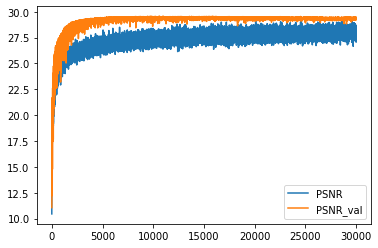

In [22]:
from matplotlib import pyplot as plt


plt.plot(PSNR_list, label='PSNR')
plt.plot(PSNR_val_list, label='PSNR_val')
plt.legend()
plt.savefig('PSNR.png')

### テスト

In [23]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from pathlib import Path
from math import log10


save_dir = os.path.join(g_drive_dir,'pics')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

test_set = DatasetFromFolderEval(image_dir='/content/General-100/test', scale_factor=4)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

# model.load_state_dict(torch.load(opt.weight_path, map_location='cuda' if opt.cuda else 'cpu'))

criterion = nn.MSELoss()

model.eval()
total_loss, total_psnr = 0, 0
total_loss_b, total_psnr_b = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs,interpolated, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)

        prediction = model(inputs)
        # print(f"prediction size:{prediction.size()}")
        # print(f"target size:{targets.size()}")
        loss = criterion(prediction, targets)
        total_loss += loss.data
        total_psnr += 10 * log10(1 / loss.data)

        loss = criterion(prediction, targets)
        total_loss_b += loss.data
        total_psnr_b += 10 * log10(1 / loss.data)

        save_image(prediction, Path(save_dir) / '{}_sr.png'.format(batch[3][0]), nrow=1)
        save_image(interpolated, Path(save_dir) / '{}_lr.png'.format(batch[3][0]), nrow=1)
        save_image(targets, Path(save_dir) / '{}_hr.png'.format(batch[3][0]), nrow=1)

print("===> [Bicubic] Avg. Loss: {:.4f}, PSNR: {:.4f} dB".format(total_loss_b / len(test_loader), total_psnr_b / len(test_loader)))
print("===> [SRCNN] Avg. Loss: {:.4f}, PSNR: {:.4f} dB".format(total_loss / len(test_loader), total_psnr / len(test_loader)))

===> [Bicubic] Avg. Loss: 0.0021, PSNR: 29.3421 dB
===> [SRCNN] Avg. Loss: 0.0021, PSNR: 29.3421 dB


### 学習済みモデルを利用する

In [24]:
# githubから30000epoch学習済みモデルをダウンロード
!wget -O SRResNet_epoch_30000.pth https://github.com/YuichiKZ/pytorch_sr/blob/main/weights/SRResNet_epoch_30000.pth?raw=true

--2022-08-21 04:43:40--  https://github.com/YuichiKZ/pytorch_sr/blob/main/weights/SRResNet_epoch_30000.pth?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YuichiKZ/pytorch_sr/raw/main/weights/SRResNet_epoch_30000.pth [following]
--2022-08-21 04:43:40--  https://github.com/YuichiKZ/pytorch_sr/raw/main/weights/SRResNet_epoch_30000.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YuichiKZ/pytorch_sr/main/weights/SRResNet_epoch_30000.pth [following]
--2022-08-21 04:43:40--  https://raw.githubusercontent.com/YuichiKZ/pytorch_sr/main/weights/SRResNet_epoch_30000.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [12]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from pathlib import Path
from math import log10


save_dir = os.path.join(g_drive_dir,'pics')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)


test_set = DatasetFromFolderEval(image_dir='/content/General-100/test', scale_factor=4)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

model = SRResnet(scale_factor=4).to(device)
model.load_state_dict(torch.load("/content/SRResNet_epoch_30000.pth"))

criterion = nn.MSELoss()

model.eval()
total_loss, total_psnr = 0, 0
total_loss_b, total_psnr_b = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs,interpolated, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        
        prediction = model(inputs)
        loss = criterion(prediction, targets)
        total_loss += loss.data
        total_psnr += 10 * log10(1 / loss.data)

        loss = criterion(prediction, targets)
        total_loss_b += loss.data
        total_psnr_b += 10 * log10(1 / loss.data)

        save_image(prediction, Path(save_dir) / '{}_sr.png'.format(batch[3][0]), nrow=1)
        save_image(interpolated, Path(save_dir) / '{}_lr.png'.format(batch[3][0]), nrow=1)
        save_image(targets, Path(save_dir) / '{}_hr.png'.format(batch[3][0]), nrow=1)

print("===> [Bicubic] Avg. Loss: {:.4f}, PSNR: {:.4f} dB".format(total_loss_b / len(test_loader), total_psnr_b / len(test_loader)))
print("===> [SRCNN] Avg. Loss: {:.4f}, PSNR: {:.4f} dB".format(total_loss / len(test_loader), total_psnr / len(test_loader)))

===> [Bicubic] Avg. Loss: 0.0021, PSNR: 29.3421 dB
===> [SRCNN] Avg. Loss: 0.0021, PSNR: 29.3421 dB
